<a href="https://colab.research.google.com/github/lilydoggy0714-cmyk/MNIST/blob/main/W2%E9%AB%98%E6%95%8F%E7%B6%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random, time

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [4]:
batch_size = 128
z_dim = 100            # 隨機噪聲維度
num_classes = 10       # MNIST 0~9
hidden_dim = 256       # 調整隱藏層大小
epochs = 30            # 訓練迴圈數
lr = 2e-4              # Adam學習率
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # 標準化到 [-1, 1]
])
trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]


In [6]:
#建立模型
class Generator(nn.Module):
    def __init__(self, z_dim, num_classes, img_shape):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)  # one-hot embedding

        self.model = nn.Sequential(
            nn.Linear(z_dim + num_classes, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.BatchNorm1d(hidden_dim*2),
            nn.ReLU(True),
            nn.Linear(hidden_dim*2, int(np.prod(img_shape))),
            nn.Tanh()
        )
        self.img_shape = img_shape

    def forward(self, noise, labels):
        # labels 轉 one-hot
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *self.img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self, num_classes, img_shape):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)) + num_classes, hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        self.img_shape = img_shape

    def forward(self, img, labels):
        label_input = self.label_emb(labels)
        d_in = torch.cat((img.view(img.size(0), -1), label_input), -1)
        validity = self.model(d_in)
        return validity

In [7]:
img_shape = (1, 28, 28)
generator = Generator(z_dim, num_classes, img_shape).to(device)
discriminator = Discriminator(num_classes, img_shape).to(device)

criterion = nn.BCELoss()  # 二元交叉熵損失
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [12]:
# 訓練迴圈
print("開始訓練 cGAN ...")
start_time = time.time()
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size_curr = imgs.size(0)

        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # Label smoothing: 真實樣本的標籤不設成1，而是0.9
        valid = torch.full((batch_size_curr, 1), 0.9, device=device)
        fake = torch.full((batch_size_curr, 1), 0.0, device=device)

        # --------- 訓練 Generator ---------
        optimizer_G.zero_grad()
        z = torch.randn(batch_size_curr, z_dim, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size_curr,), device=device)
        gen_imgs = generator(z, gen_labels)
        g_loss = criterion(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # --------- 訓練 Discriminator ---------
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs, labels), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch+1}/{epochs}]  D loss: {d_loss.item():.4f}  G loss: {g_loss.item():.4f}")
end_time = time.time()  # 結束計時
elapsed_time = end_time - start_time  # 總秒數

hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)
print(f"訓練模型時間: {hours} 時 {minutes} 分 {seconds} 秒")

開始訓練 cGAN ...
Epoch [1/30]  D loss: 0.6575  G loss: 0.7960
Epoch [2/30]  D loss: 0.6145  G loss: 0.9995
Epoch [3/30]  D loss: 0.5861  G loss: 0.8584
Epoch [4/30]  D loss: 0.6393  G loss: 0.9887
Epoch [5/30]  D loss: 0.6320  G loss: 0.8760
Epoch [6/30]  D loss: 0.6319  G loss: 0.7927
Epoch [7/30]  D loss: 0.6076  G loss: 0.8827
Epoch [8/30]  D loss: 0.6341  G loss: 0.9785
Epoch [9/30]  D loss: 0.6638  G loss: 1.0363
Epoch [10/30]  D loss: 0.6225  G loss: 0.8874
Epoch [11/30]  D loss: 0.6715  G loss: 0.8652
Epoch [12/30]  D loss: 0.6121  G loss: 0.9201
Epoch [13/30]  D loss: 0.6333  G loss: 1.0535
Epoch [14/30]  D loss: 0.6630  G loss: 1.1199
Epoch [15/30]  D loss: 0.6353  G loss: 0.7543
Epoch [16/30]  D loss: 0.6483  G loss: 0.8401
Epoch [17/30]  D loss: 0.6691  G loss: 0.7055
Epoch [18/30]  D loss: 0.6627  G loss: 0.9054
Epoch [19/30]  D loss: 0.6867  G loss: 0.9663
Epoch [20/30]  D loss: 0.6431  G loss: 0.9081
Epoch [21/30]  D loss: 0.6241  G loss: 0.9404
Epoch [22/30]  D loss: 0.6405

生成 100 張影像耗時: 0.004846 秒


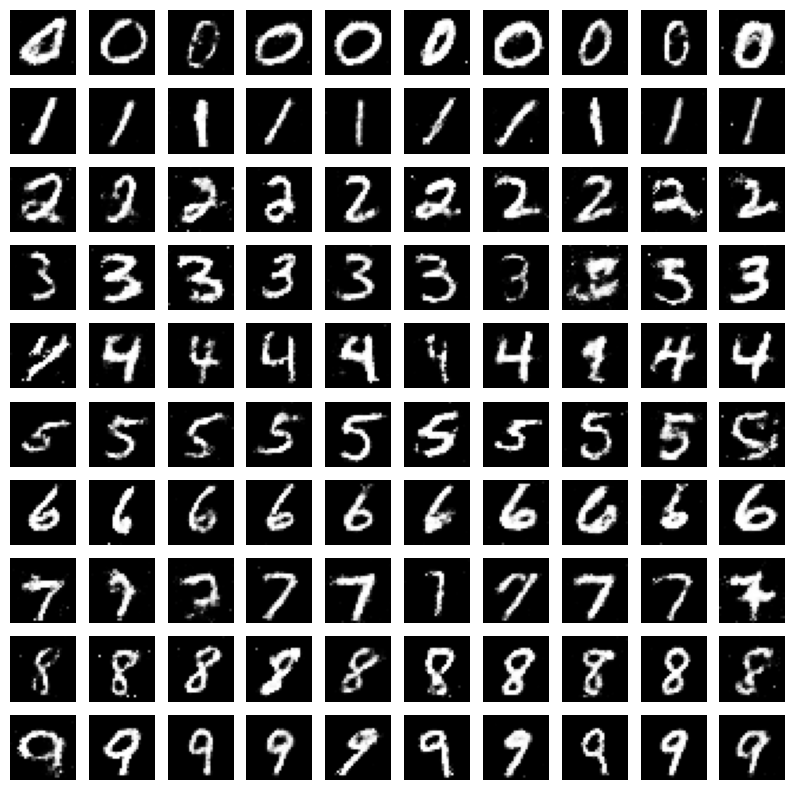

In [13]:
# 測試：生成數字 0–9 各 10 張
generator.eval()
n_row = 10
z = torch.randn(n_row**2, z_dim, device=device)
labels = torch.tensor([i for i in range(n_row) for _ in range(n_row)], device=device)

# 加入計時器
start_time = time.time()
gen_imgs = generator(z, labels).cpu().detach()
end_time = time.time()
print(f"生成 {n_row*n_row} 張影像耗時: {end_time - start_time:.6f} 秒")

# 把影像轉回 [0,1]
gen_imgs = (gen_imgs + 1) / 2.0

# 畫圖 (10x10)
fig, axs = plt.subplots(n_row, n_row, figsize=(10,10))
cnt = 0
for i in range(n_row):
    for j in range(n_row):
        axs[i,j].imshow(gen_imgs[cnt,0,:,:], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()